# CellStrat Hub Pack - Generative Adversarial Network

### GAN10 - PrivGAN model

#### Kernel: Tensorflow 2.4

In [1]:
import os
import numpy as np
import pandas as pd
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Reshape, Dense, Dropout, Flatten, LeakyReLU, Conv2D, MaxPooling2D, ZeroPadding2D, Conv2DTranspose, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import initializers
from privacygan import privacy_gan as pg
from privacygan.cifar import cifar_gan
import warnings

print(tf.__version__)

2021-10-01 08:29:18.382929: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-01 08:29:18.383143: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-01 08:29:18.491130: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


2.4.1


In [2]:
# Load CIFAR-10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_all = np.concatenate((X_train,X_test))

(n, d1, d2, d3) = X_all.shape

if d3 !=3:
    X_all = np.moveaxis(X_all, 1, 3)
    
X_all = np.float32(X_all)
X_all = (X_all / 255 - 0.5) * 2
X_all = np.clip(X_all, -1, 1)

#Generate training test split
frac = 0.1 
n = int(frac*len(X_all))
l = np.array(range(len(X_all)))
l = np.random.choice(l,len(l),replace = False)
X = X_all[l[:n]]
X_comp = X_all[l[n:]]

print(X.shape)
print(X_comp.shape)

170500096/170498071 [==============================] - 2s 0us/step
(6000, 32, 32, 3)
(54000, 32, 32, 3)


In [3]:
#Specify models 
generator = cifar_gan.CIFAR_Generator()
discriminator = cifar_gan.CIFAR_Discriminator()
generators = [cifar_gan.CIFAR_Generator(),cifar_gan.CIFAR_Generator()]
discriminators = [cifar_gan.CIFAR_Discriminator(),cifar_gan.CIFAR_Discriminator()]
pDisc = cifar_gan.CIFAR_DiscriminatorPrivate(OutSize = 2)

In [4]:
(generator, discriminator, dLosses, gLosses) = pg.SimpGAN(X, epochs = 1, 
                                                          generator = generator, 
                                                          discriminator = discriminator,
                                                          batchSize=256)

Epochs: 1
Batch size: 256
Batches per epoch: 23.4375


2021-10-01 08:29:25.334991: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-01 08:29:25.353299: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


epoch = 1/1, d_loss=0.554, g_loss=0.783                                                                                                                    


In [5]:
#perform white box attack
Acc = pg.WBattack(X,X_comp, discriminator)

White-box attack accuracy: 0.099


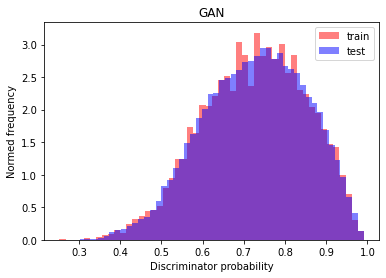

In [6]:
#plot distribution of discriminator scores of training and test set
plt.hist(discriminator.predict(X)[:,0],color = 'r', alpha = 0.5, label = 'train', density = True, bins = 50)
plt.hist(discriminator.predict(X_comp)[:,0],color = 'b', alpha = 0.5, label = 'test', density = True, bins = 50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('GAN')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

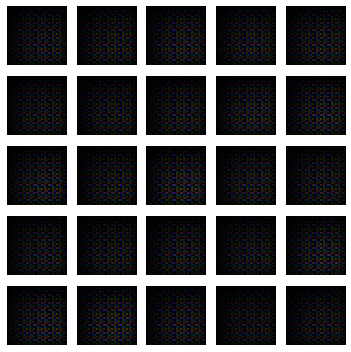

In [7]:
noise = np.random.normal(0, 1, size=[X.shape[0], 100])
generatedImages = generator.predict(noise)
temp = generatedImages[:25].reshape(25, 32, 32, 3)
plt.figure(figsize=(5, 5))
for i in range(temp.shape[0]):
    plt.subplot(5,5, i+1)
    plt.imshow(temp[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()

In [8]:
tf.keras.backend.clear_session()
optim = Adam(lr=0.0002, beta_1=0.5)
generator = cifar_gan.CIFAR_Generator(optim = Adam(lr=0.0002, beta_1=0.5))
discriminator = cifar_gan.CIFAR_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5))
generators = [cifar_gan.CIFAR_Generator(optim = Adam(lr=0.0002, beta_1=0.5)),
              cifar_gan.CIFAR_Generator(optim = Adam(lr=0.0002, beta_1=0.5))]
discriminators = [cifar_gan.CIFAR_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5)),
                  cifar_gan.CIFAR_Discriminator(optim = Adam(lr=0.0002, beta_1=0.5))]
pDisc = cifar_gan.CIFAR_DiscriminatorPrivate(OutSize = 2,
                                     optim = Adam(lr=0.0002, beta_1=0.5))
(generators, discriminators, _, dLosses, dpLosses, gLosses)= pg.privGAN(X, epochs = 1,
                                                                           disc_epochs=1,
                                                                           generators = generators, 
                                                                           discriminators = discriminators,
                                                                           pDisc = pDisc,
                                                                           optim = optim,
                                                                           privacy_ratio=1.0,
                                                                           batchSize=256)

24/24 [==============================] - 18s 748ms/step - loss: 0.6943 - val_loss: 0.6903
dp-Accuracy: 0.5446666666666666
Epochs: 1
Batch size: 256
Batches per epoch: 11
epoch = 0/1, batch = 10/11                                                                                                     
dLosses = [0.57449888 0.56553828]
dpLosses = 0.0
gLosses = 2.7825837352059106
dp-Accuracy: 0.0


In [9]:
#perform white box attack
pg.WBattack_priv(X,X_comp, discriminators)

White-box attack accuracy (max): 0.0965
White-box attack accuracy (mean): 0.1


(0.0965, 0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

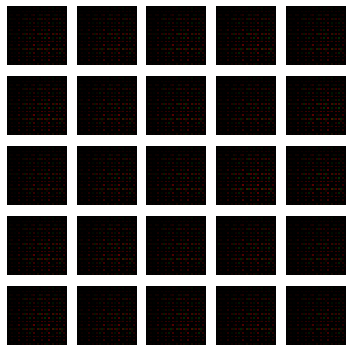

In [10]:
noise = np.random.normal(0, 1, size=[X.shape[0], 100])
generatedImages = generators[0].predict(noise)
temp = generatedImages[:25].reshape(25, 32, 32, 3)
plt.figure(figsize=(5, 5))
for i in range(temp.shape[0]):
    plt.subplot(5,5, i+1)
    plt.imshow(temp[i], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()

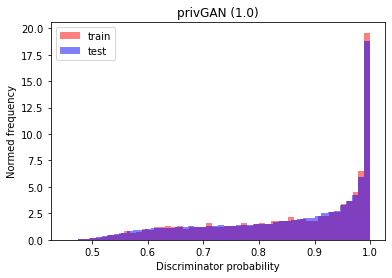

In [11]:
plt.hist(discriminators[0].predict(X)[:,0],color = 'r', alpha = 0.5, label = 'train', density = True, bins = 50)
plt.hist(discriminators[0].predict(X_comp)[:,0],color = 'b', alpha = 0.5, label = 'test', density = True, bins = 50)
plt.xlabel('Discriminator probability')
plt.ylabel('Normed frequency')
plt.title('privGAN (1.0)')
plt.legend()